In [1]:
import os
import glob
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import albumentations as A
import onnxruntime

In [2]:
# Loading the test images path 

PATH = 'C:\\Users\\Z0047TWV\\Desktop\\Brain MRI Hackathon\\Test images'

mask_files = glob.glob(PATH + '\\*_mask*')
image_files = [file.replace('\\_mask', '') for file in mask_files]

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

samples_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

samples_df

,image_path,mask_path,diagnosis
0,C:\Users\Z0047TWV\Desktop\Brain MRI Hackathon\...,C:\Users\Z0047TWV\Desktop\Brain MRI Hackathon\...,1
1,C:\Users\Z0047TWV\Desktop\Brain MRI Hackathon\...,C:\Users\Z0047TWV\Desktop\Brain MRI Hackathon\...,1
2,C:\Users\Z0047TWV\Desktop\Brain MRI Hackathon\...,C:\Users\Z0047TWV\Desktop\Brain MRI Hackathon\...,1
3,C:\Users\Z0047TWV\Desktop\Brain MRI Hackathon\...,C:\Users\Z0047TWV\Desktop\Brain MRI Hackathon\...,1


In [3]:
# Pre-processing test images

def load_sample(idx):
    image = cv2.imread(samples_df.iloc[idx, 0])
    image = (np.array(image).astype(np.float32))/255.
    mask = cv2.imread(samples_df.iloc[idx, 1], 0)
    
    test_transform = A.Compose([
                    A.Resize(width=128, height=128, p=1.0)
                    ])
    
    aug = test_transform(image=image, mask=mask)
    image = aug['image']
    mask = aug['mask']
            
    image = image.transpose((2,0,1))
    
    #image normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    std_vec = np.array([0.229, 0.224, 0.225])

    for i in range(image.shape[0]):
        image[i, :, :] = (image[i, :, :] - mean_vec[i]) / (std_vec[i])
    
    
    mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))

    return image, mask

In [4]:
test_img, test_mask = load_sample(3)

In [5]:
test_img.shape, test_mask.shape

((3, 128, 128), (1, 128, 128))

In [6]:
# Creating batch of single image 

input_img = np.stack([test_img]*1)
input_img.shape

(1, 3, 128, 128)

In [7]:
# Loading the onnx model 
model_onnx = 'C:\\Users\\Z0047TWV\\Desktop\\Brain MRI Hackathon\\Models\\brain-mri-unet.onnx'

session = onnxruntime.InferenceSession(model_onnx, None, providers= ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

In [8]:
# Prediction 
result = session.run([output_name], {input_name: input_img})
result

[array([[[[2.09212303e-05, 1.17719173e-05, 1.98483467e-05, ...,
           1.20103359e-05, 2.36630440e-05, 3.69548798e-05],
          [1.77919865e-05, 1.23977661e-05, 3.13818455e-05, ...,
           1.43945217e-05, 5.99026680e-05, 8.67843628e-05],
          [7.77840614e-06, 4.26173210e-06, 1.45733356e-05, ...,
           1.38580799e-05, 3.57627869e-05, 9.12249088e-05],
          ...,
          [6.16908073e-06, 2.74181366e-06, 2.73883343e-05, ...,
           1.55270100e-05, 8.01682472e-06, 1.08480453e-05],
          [1.06096268e-05, 3.75509262e-06, 1.03116035e-05, ...,
           1.11162663e-05, 1.41859055e-05, 2.52127647e-05],
          [1.85370445e-05, 5.30481339e-06, 7.21216202e-06, ...,
           9.26852226e-06, 1.46627426e-05, 1.89840794e-05]]]],
       dtype=float32)]

In [9]:
arr = np.array(result).astype(np.float32)
arr = arr * 255
arr = arr[0, 0, 0, :, :].astype(np.uint8)
arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
arr.mean(), arr.var(), arr.min(), arr.max(), arr.shape

(0.00933837890625, 0.061619337648153305, 0, 14, (128, 128))

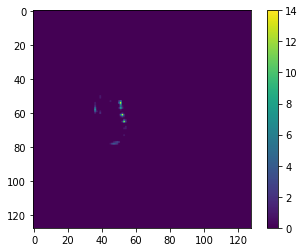

In [11]:
plt.imshow(arr)
plt.colorbar()

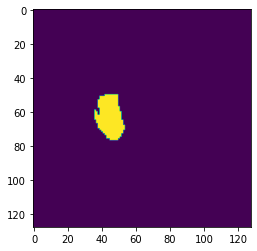

In [12]:
maskimg = test_mask[0, :, :]
plt.imshow(maskimg)